### MNIST multi-class classification with XGBoost

In [ ]:
from scipy.io import loadmat

import numpy as np

import xgboost as xgb
from xgboost import DMatrix

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import time

In [ ]:
data = loadmat("MNIST.mat")
#print(data.keys())

train_fea = data['train_fea']
train_gnd = data['train_gnd']-1
test_fea = data['test_fea']
test_gnd = data['test_gnd']-1




### Train/Test Split

In [ ]:
X_train, y_train = shuffle(train_fea, train_gnd, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.083333, random_state=42
)

X_test, y_test = shuffle(test_fea, test_gnd, random_state=42)

dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_val, label=y_val)
dtest = DMatrix(X_test, label=y_test)

# X_train shape: (55k, 784)
# y_train shape: (55k, 1)

# X_val shape: (5k, 784)
# y_val shape: (5k, 1)

# X_test shape: (10k, 784)
# y_test shape: (10k, 1)

### XGBoost without cross-validation

In [ ]:
params = {
    "objective": "multi:softprob",
    "num_class": 10,
    "tree_method": "hist",
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "max_depth": 5,
    "eta": 0.1, # learning rate
    "eval_metric": "mlogloss",
    "seed": 42,
    "nthread": -1
}

evals = [(dtrain, 'train'), (dval, 'val')]

start = time.time()
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)
end = time.time()
train_time = end - start

start = time.time()
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)
end = time.time()
test_time = end - start

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

evals_result = model.evals_result()

final_error = evals_result['val']['mlogloss'][-1]  
final_error = round(final_error * 100, 2)

print(f"Training time: {train_time:.2f}s")
print(f"Inference time: {test_time:.4f}s")
print(f"Accuracy: {acc:.3f}")
print(f"Final error: {final_error}%")
print(f"Best number of trees: {model.best_iteration}")
print(f"Classification report:\n{report}")

[0]	train-mlogloss:1.99460	val-mlogloss:1.99795
[100]	train-mlogloss:0.07118	val-mlogloss:0.13228
[200]	train-mlogloss:0.01814	val-mlogloss:0.08718
[300]	train-mlogloss:0.00591	val-mlogloss:0.07454
[400]	train-mlogloss:0.00252	val-mlogloss:0.07056
[500]	train-mlogloss:0.00137	val-mlogloss:0.06880
[600]	train-mlogloss:0.00090	val-mlogloss:0.06804
[700]	train-mlogloss:0.00067	val-mlogloss:0.06798
[702]	train-mlogloss:0.00067	val-mlogloss:0.06797
Training time: 580.56s
Inference time: 0.2712s
Accuracy: 0.981
Best number of trees: 652
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1135
           1       0.97      0.98      0.98      1032
           2       0.98      0.98      0.98      1010
           3       0.98      0.98      0.98       982
           4       0.99      0.98      0.98       892
           5       0.98      0.98      0.98       958
           6       0.98      0.97      0.98      1028
       

Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

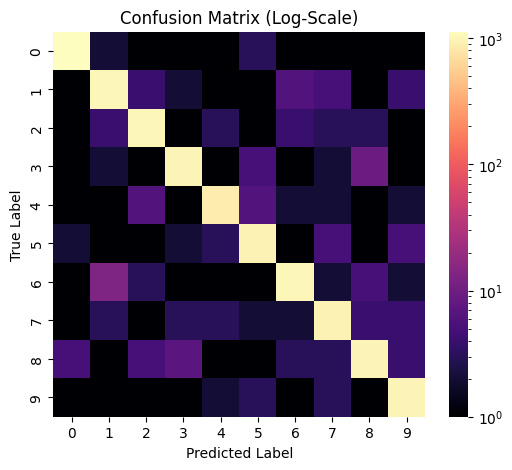

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")

### XGBoost with cross-validation

In [ ]:
results = {}


# WITH EARLY STOPPING

print("=== CV WITH EARLY STOPPING ===")

start = time.time()
cv_results_es = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=3,
    stratified=True,
    early_stopping_rounds=50,
    verbose_eval=100,
    seed=42,
    as_pandas=True
)
end = time.time()

results["cv_time_es"] = end - start
results["best_rounds_es"] = len(cv_results_es)

print(f"CV time (ES): {results['cv_time_es']:.2f}s")
print(f"Best rounds (ES): {results['best_rounds_es']}")

start = time.time()
model_es = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=results["best_rounds_es"]
)
results["train_time_es"] = time.time() - start

start = time.time()
y_pred_es = np.argmax(model_es.predict(dtest), axis=1)
results["test_time_es"] = time.time() - start

results["acc_es"] = accuracy_score(y_test, y_pred_es)
results["report_es"] = classification_report(y_test, y_pred_es)

final_error_es = cv_results_es["test-mlogloss-mean"].iloc[-1]
final_error_es = round(final_error_es * 100, 2)

# WITHOUT EARLY STOPPING
print("\n=== CV WITHOUT EARLY STOPPING ===")

start = time.time()
cv_results_ns = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=3,
    stratified=True,
    early_stopping_rounds=None,
    verbose_eval=100,
    seed=42,
    as_pandas=True
)
end = time.time()

results["cv_time_ns"] = end - start
results["best_rounds_ns"] = len(cv_results_ns)   # always = 2000

print(f"CV time (No Stop): {results['cv_time_ns']:.2f}s")
print(f"Total rounds (No Stop): {results['best_rounds_ns']}")

start = time.time()
model_ns = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=results["best_rounds_ns"]
)
results["train_time_ns"] = time.time() - start


start = time.time()
y_pred_ns = np.argmax(model_ns.predict(dtest), axis=1)
results["test_time_ns"] = time.time() - start

results["acc_ns"] = accuracy_score(y_test, y_pred_ns)
results["report_ns"] = classification_report(y_test, y_pred_ns)

final_error_ns = cv_results_ns["test-mlogloss-mean"].iloc[-1]
final_error_ns = round(final_error_ns * 100, 2)

# SUMMARY

print("\n\n========== SUMMARY ==========")

print(f"WITH EARLY STOPPING:")
print(f"  Best rounds: {results['best_rounds_es']}")
print(f"  Accuracy: {results['acc_es']:.3f}")
print(f"Final CV error (ES): {final_error_es}%")
print(results["report_es"])

print(f"\nWITHOUT EARLY STOPPING:")
print(f"  Rounds: {results['best_rounds_ns']}")
print(f"  Accuracy: {results['acc_ns']:.3f}")
print(f"Final CV error (NS): {final_error_ns}%")
print(results["report_ns"])


[0]	train-mlogloss:1.98773+0.00214	test-mlogloss:1.99415+0.00241
[100]	train-mlogloss:0.06015+0.00083	test-mlogloss:0.13644+0.00287
[200]	train-mlogloss:0.01264+0.00030	test-mlogloss:0.09443+0.00400
[300]	train-mlogloss:0.00398+0.00009	test-mlogloss:0.08408+0.00419
[400]	train-mlogloss:0.00186+0.00003	test-mlogloss:0.08133+0.00433
[500]	train-mlogloss:0.00115+0.00001	test-mlogloss:0.08086+0.00444
[588]	train-mlogloss:0.00086+0.00001	test-mlogloss:0.08100+0.00444
Cross-validation training time: 1309.75s
Best number of boosting rounds from CV: 539
Training time (best model): 526.33s
Inference time: 0.2139s
Accuracy: 0.981
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1135
           1       0.97      0.98      0.98      1032
           2       0.98      0.98      0.98      1010
           3       0.98      0.98      0.98       982
           4       0.99      0.98      0.98       892
           5       0.98 

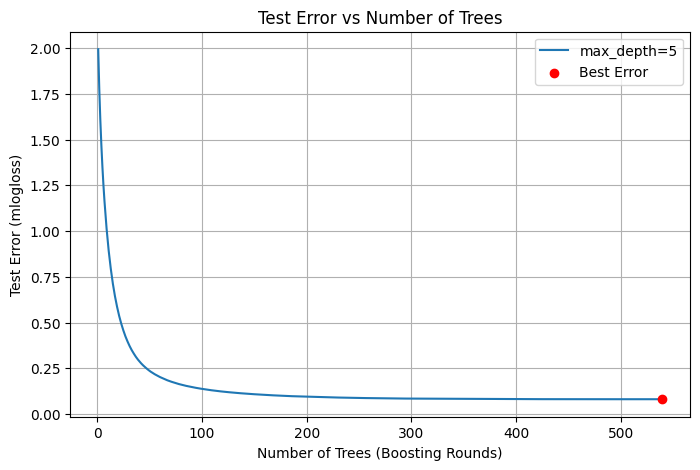

Best test error: 8.09%, Number of trees: 539, Max depth: 5


In [ ]:
import matplotlib.pyplot as plt

test_error = cv_results_ns["test-mlogloss-mean"]
num_trees = range(1, len(test_error)+1)
depths = [params['max_depth']] * len(test_error)

plt.figure(figsize=(8,5))
plt.plot(num_trees, test_error, label=f"max_depth={params['max_depth']}")
plt.xlabel("Number of Trees (Boosting Rounds)")
plt.ylabel("Test Error (mlogloss)")
plt.title("Test Error vs Number of Trees")
plt.grid(True)

best_index = test_error.idxmin()
plt.scatter(best_index + 1, test_error[best_index], color='red', zorder=5, label='Best Error')
plt.legend()
plt.savefig("graphs_part_2/MNIST_tree_error_vs_trees.pdf")
plt.show()

# Save only the best test error to file
best_error = round(test_error[best_index] * 100, 2) 
best_num_trees = best_index + 1
best_depth = params['max_depth']

with open("test_errors_part_2/test_error_MNIST.txt", 'w') as file:
    file.write(f"test error {best_error}%, {best_num_trees} trees, maximum depth {best_depth}\n")

print(f"Best test error: {best_error}%, Number of trees: {best_num_trees}, Max depth: {best_depth}")


Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

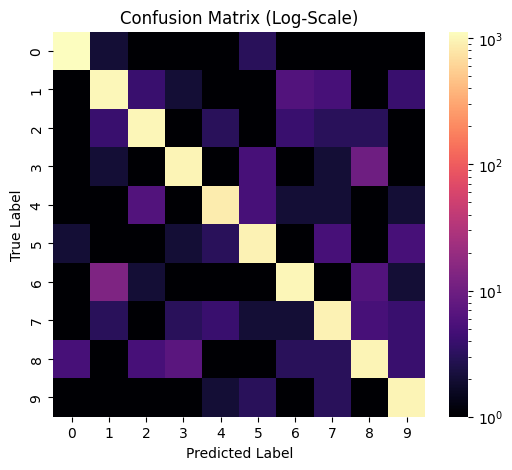

In [ ]:
cm = confusion_matrix(y_test, y_pred_es)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")

### Using LeNet-5 Features:
 - Each image is represented as an 800-dimensional feature vector, obtained from a pretrained LeNet5 convolutional neural net (the output of the neurons at layer conv2)
- The images are the same as for the pixel-based images and appear in the same order

In [ ]:
data_lenet = loadmat("MNIST-LeNet5.mat")
#print(data_lenet.keys())

train_fea = data_lenet['train_fea']
train_gnd = data_lenet['train_gnd']-1

test_fea = data_lenet['test_fea']
test_gnd = data_lenet['test_gnd']-1

# train_fea shape: (60k, 800)
# train_gnd shape: (60k, 1)
# test_fea shape: (10k, 800)
# test_gnd shape: (10k, 1)

In [ ]:
X_train, y_train = shuffle(train_fea, train_gnd, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.083333, random_state=42
)

X_test, y_test = shuffle(test_fea, test_gnd, random_state=42)

dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_val, label=y_val)
dtest = DMatrix(X_test, label=y_test)

In [ ]:
params = {
    "objective": "multi:softprob",
    "num_class": 10,
    "tree_method": "hist",
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "max_depth": 5,
    "eta": 0.1, # learning rate
    "eval_metric": "mlogloss",
    "seed": 42,
    "nthread": -1
}

evals = [(dtrain, 'train'), (dval, 'val')]

start = time.time()
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)
end = time.time()
train_time = end - start

start = time.time()
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)
end = time.time()
test_time = end - start

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

evals_result = model.evals_result()

final_error = evals_result['val']['mlogloss'][-1]  
final_error = round(final_error * 100, 2)

print(f"Training time: {train_time:.2f}s")
print(f"Inference time: {test_time:.4f}s")
print(f"Accuracy: {acc:.3f}")
print(f"Final error: {final_error}%")
print(f"Best number of trees: {model.best_iteration}")
print(f"Classification report:\n{report}")

[0]	train-mlogloss:1.90772	val-mlogloss:1.91520
[100]	train-mlogloss:0.00837	val-mlogloss:0.04617
[200]	train-mlogloss:0.00105	val-mlogloss:0.03584
[300]	train-mlogloss:0.00045	val-mlogloss:0.03397
[400]	train-mlogloss:0.00030	val-mlogloss:0.03359
[471]	train-mlogloss:0.00025	val-mlogloss:0.03357
Training time: 497.93s
Inference time: 0.1943s
Accuracy: 0.990
Best number of trees: 421
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1135
           1       0.99      0.99      0.99      1032
           2       0.99      0.99      0.99      1010
           3       0.99      0.99      0.99       982
           4       0.99      0.98      0.99       892
           5       0.99      0.99      0.99       958
           6       0.98      0.99      0.99      1028
           7       0.99      0.99      0.99       974
           8       0.99      0.98      0.99      1009
           9       0.99      0.99      0.99      

Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

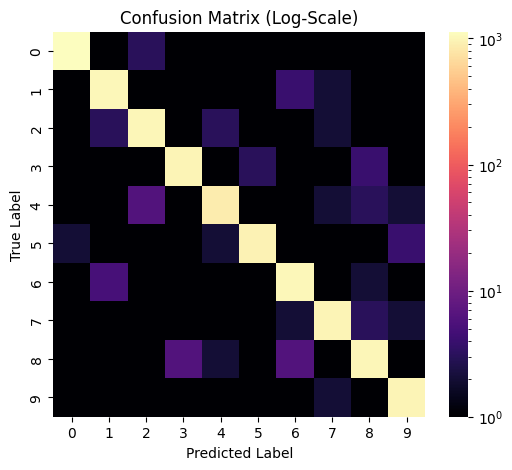

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma", norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")

In [ ]:
import time
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


# CROSS-VALIDATION WITH EARLY STOPPING

print("\n=== Running CV WITH early stopping ===")

start_es = time.time()
cv_results_es = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=3,
    stratified=True,
    early_stopping_rounds=50,
    verbose_eval=100,
    seed=42,
    as_pandas=True
)
end_es = time.time()

best_n_es = len(cv_results_es)

print(f"CV time (early stopping): {end_es - start_es:.2f}s")
print(f"Best rounds (early stopping): {best_n_es}")


start_train_es = time.time()
model_es = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_es,
    verbose_eval=False
)
end_train_es = time.time()

start_test_es = time.time()
y_pred_es = np.argmax(model_es.predict(dtest), axis=1)
end_test_es = time.time()

acc_es = accuracy_score(y_test, y_pred_es)
report_es = classification_report(y_test, y_pred_es)

final_error_es = cv_results_es["test-mlogloss-mean"].iloc[-1]
final_error_es = round(final_error_es * 100, 2)

print(f"Training time (ES): {end_train_es - start_train_es:.2f}s")
print(f"Inference time (ES): {end_test_es - start_test_es:.4f}s")
print(f"Accuracy (ES): {acc_es:.3f}")
print(f"Final CV error (ES): {final_error_es}%")
print(report_es)


# CROSS-VALIDATION WITHOUT EARLY STOPPING (FULL 2000 ROUNDS)

print("\n=== Running CV with NO early stopping ===")

start_ns = time.time()
cv_results_ns = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    nfold=3,
    stratified=True,
    early_stopping_rounds=None,    
    verbose_eval=100,
    seed=42,
    as_pandas=True
)
end_ns = time.time()

best_n_ns = len(cv_results_ns)  # will be exactly 2000

print(f"CV time (no stopping): {end_ns - start_ns:.2f}s")
print(f"Best rounds (no stopping): {best_n_ns}")



start_train_ns = time.time()
model_ns = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_ns,
    verbose_eval=False
)
end_train_ns = time.time()


start_test_ns = time.time()
y_pred_ns = np.argmax(model_ns.predict(dtest), axis=1)
end_test_ns = time.time()

acc_ns = accuracy_score(y_test, y_pred_ns)
report_ns = classification_report(y_test, y_pred_ns)

final_error_ns = cv_results_ns["test-mlogloss-mean"].iloc[-1]
final_error_ns = round(final_error_ns * 100, 2)

print(f"Training time (NS): {end_train_ns - start_train_ns:.2f}s")
print(f"Inference time (NS): {end_test_ns - start_test_ns:.4f}s")
print(f"Accuracy (NS): {acc_ns:.3f}")
print(f"Final CV error (NS): {final_error_ns}%")
print(report_ns)


[0]	train-mlogloss:1.90774+0.00111	test-mlogloss:1.91512+0.00205
[100]	train-mlogloss:0.00643+0.00018	test-mlogloss:0.04937+0.00203
[200]	train-mlogloss:0.00094+0.00002	test-mlogloss:0.04016+0.00204
[300]	train-mlogloss:0.00048+0.00001	test-mlogloss:0.03898+0.00202
[400]	train-mlogloss:0.00035+0.00000	test-mlogloss:0.03875+0.00198
[500]	train-mlogloss:0.00029+0.00000	test-mlogloss:0.03868+0.00204
[572]	train-mlogloss:0.00026+0.00000	test-mlogloss:0.03866+0.00201
Cross-validation training time: 1335.11s
Best number of boosting rounds from CV: 523
Training time (best model): 556.87s
Inference time: 0.1544s
Accuracy: 0.990
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1135
           1       0.99      0.99      0.99      1032
           2       0.99      0.99      0.99      1010
           3       0.99      0.99      0.99       982
           4       0.99      0.98      0.99       892
           5       0.99 

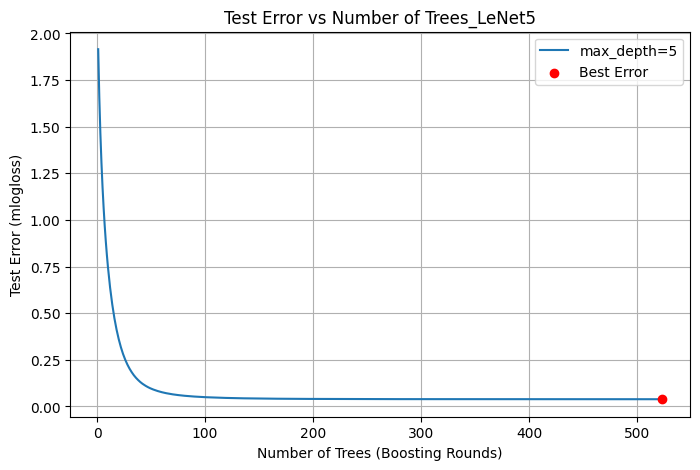

Best test error: 3.87%, Number of trees: 523, Max depth: 5


In [ ]:
import matplotlib.pyplot as plt

test_error = cv_results_es["test-mlogloss-mean"]
num_trees = range(1, len(test_error)+1)
depths = [params['max_depth']] * len(test_error)

plt.figure(figsize=(8,5))
plt.plot(num_trees, test_error, label=f"max_depth={params['max_depth']}")
plt.xlabel("Number of Trees (Boosting Rounds)")
plt.ylabel("Test Error (mlogloss)")
plt.title("Test Error vs Number of Trees_LeNet5")
plt.grid(True)

best_index = test_error.idxmin()
plt.scatter(best_index + 1, test_error[best_index], color='red', zorder=5, label='Best Error')
plt.legend()
plt.savefig("graphs_part_2/LeNet5_tree_error_vs_trees.pdf")
plt.show()

# Save only the best test error to file
best_error = round(test_error[best_index] * 100, 2) 
best_num_trees = best_index + 1
best_depth = params['max_depth']

with open("test_errors_part_2/test_error_LeNet5.txt", 'w') as file:
    file.write(f"test error {best_error}%, {best_num_trees} trees, maximum depth {best_depth}\n")

print(f"Best test error: {best_error}%, Number of trees: {best_num_trees}, Max depth: {best_depth}")


Text(0.5, 1.0, 'Confusion Matrix (Log-Scale)')

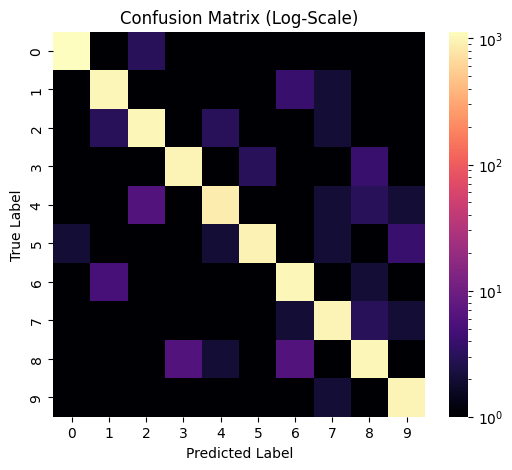

In [ ]:
cm = confusion_matrix(y_test, y_pred_es)

cm_safe = cm.copy()
cm_safe[cm_safe == 0] = 1 # needed for log norm

plt.figure(figsize=(6,5))
sns.heatmap(cm_safe, cmap="magma",   norm=LogNorm(vmin=1, vmax=cm_safe.max()), annot=False, fmt='d', cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Log-Scale)")